This snippet showcases a sample Machine Learning pipeline for        
supervised learning using the HMEQ data set. The steps include:  
                                                                      
1.  PREPARE AND EXPLORE  
  a) Load data set into CAS  
  b) Explore  
  c) Partition  
  d) Impute  
  e) Identify variables that explain variance  
<br>
2. PERFORM SUPERVISED LEARNING  
  a) Fit model using random forest  
<br>
3. EVALUATE AND IMPLEMENT  
  a) Score the data  
  b) Assess model performance  
  c) Generate ROC and Lift charts     

### Import packages

In [1]:
from swat import *
from pprint import pprint
from matplotlib import pyplot as plt
import pandas as pd
from swat.render import render_html
%matplotlib inline

### CAS Server connection details

In [2]:
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'
indata_dir="data"
indata="hmeq"

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo="~/.authinfo", caslib="casuser")

### Import action sets

In [4]:
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")
sess.loadactionset(actionset="varReduce")

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.
NOTE: Added action set 'varReduce'.


[actionset]

 'varReduce'

+ Elapsed: 0.000595s, mem: 0.0291mb

### Set variables for input data

In [5]:
target          = "bad"
class_inputs    = ["reason", "job"]
class_vars      = [target] + class_inputs
interval_inputs = ["im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", "im_yoj", "im_ninq", "derog", "im_delinq"]
all_inputs      = interval_inputs + class_inputs

### Load data into CAS if needed

In [6]:
if not sess.table.tableExists(table=indata).exists:
    sess.loadTable(caslib="casuser", path=indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the file data/hmeq.sas7bdat available as table HMEQ in caslib CASUSER(viyauser).


### Explore and Impute missing values

#### Explore data and plot missing values

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.503529 seconds.
----------------------------------Data Summary----------------------------------


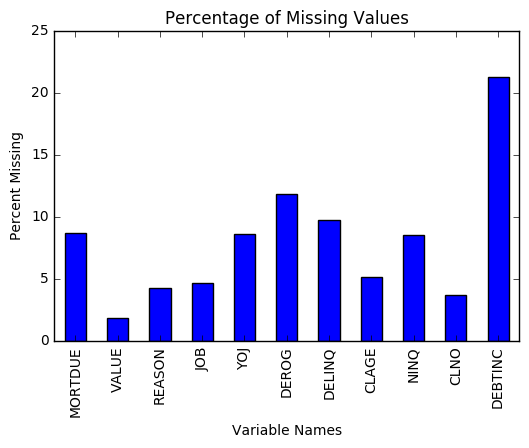

In [7]:
sess.cardinality.summarize(
  table={"name":indata}, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card=sess.CASTable('data_card')
tbl_data_card.where='_NMISS_>0'
print("Data Summary".center(80, '-')) # print title
tbl_data_card.fetch() # print obs

tbl_data_card.vars=['_VARNAME_', '_NMISS_', '_NOBS_']
allRows=20000  # Assuming max rows in data_card table is <= 20,000
df_data_card=tbl_data_card.fetch(to=allRows)['Fetch']
df_data_card['PERCENT_MISSING']=(df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100

tbl_forplot=pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax=tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names')

#### Impute missing values

In [8]:
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"hmeq_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq"}},
    {"impute":{"method":"RANDOM"}, "inputs":{"ninq"}},
    {"impute":{"method":"VALUE", "valuesContinuous":{50, 100}}, "inputs":{"debtinc", "yoj"}}
  ]
)

[TransInfo]

 Transformation Requests for HMEQ
 
   ActualName  NTransVars ImputeMethod          Seed
 0       _TR1           1         Mean           NaN
 1       _TR2           1       Median           NaN
 2       _TR3           1       Random  1.801404e+09
 3       _TR4           2        Value           NaN

[VarTransInfo]

 Variable Transformation Information for HMEQ
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous
 0    CLAGE             IM    IM_CLAGE  5652    308              179.766275
 1  DEBTINC             IM  IM_DEBTINC  4693   1267              100.000000
 2   DELINQ             IM   IM_DELINQ  5380    580                0.000000
 3     NINQ             IM     IM_NINQ  5450    510                     NaN
 4      YOJ             IM      IM_YOJ  5445    515               50.000000

[OutputCasTables]

               casLib          Name  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_prepped  5960       18   
 
                                             casTable  
 0  CASTable('hmeq_prepped', caslib='CASUSER(viyau...  

+ Elapsed: 0.022s, user: 0.017s, sys: 0.006s, mem: 9.52mb

#### Identify variables that explain variance in the target

NOTE: The CAS table 'SelectionSummary' in caslib 'CASUSER(viyauser)' has 9 rows and 9 columns.


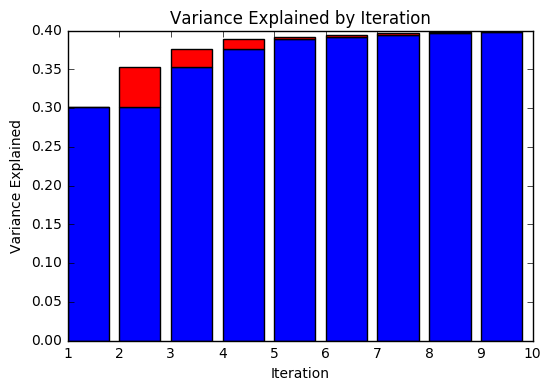

In [9]:
#/* Discriminant analysis for class target */
sess.varReduce.super(
  table={"name":"hmeq_prepped"},
  analysis="DSC",
  classVars=[{"vars":{"bad", "reason", "job"}}],
  model={
    "depVars":[{"name":target}],
    "effects":[{"vars":{"reason", "job", "im_clage", "clno", 
                        "im_debtinc", "loan", "mortdue", "value",
                        "im_yoj", "im_ninq", "derog", "im_delinq"}}]
  },
  maxeffects=8,
  outputTables={"names":{"SelectionSummary"}}  
)

# Compute Increment and Base variables
selsum=sess.CASTable("SelectionSummary")
selsum.vars=['Iteration', 'Variable', 'VarExp']
allRows=20000  # Assuming max rows in SelectionSummary table is <= 20,000
plot_df=selsum.fetch(to=allRows)['Fetch']
 
plot_df["Increment"]=0
prevVarExp=0
for i, row in plot_df.iterrows():
    if i==0:
        prevVarExp=row["VarExp"]
    else:
        plot_df.loc[i, "Increment"]=row["VarExp"]-prevVarExp
        prevVarExp=row["VarExp"]
plot_df["Base"]=plot_df["VarExp"]-plot_df["Increment"]

#/* Variance explained by Iteration plot */       
plt.bar(plot_df["Iteration"], plot_df["Base"], color='b')
plt.bar(plot_df["Iteration"], plot_df["Increment"], color='r', bottom=plot_df["Base"])
plt.xlabel("Iteration")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Iteration")
plt.show()

### Partition data into Training and Validation

In [10]:
sess.sampling.stratified(
  table={"name":"hmeq_prepped", "groupBy":"bad"},
  output={"casOut":{"name":"hmeq_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=1386683551 for sampling.


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 19}

[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

               casLib       Name Label  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_part        5960       19   
 
                                             casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(viyauser)')  

+ Elapsed: 0.0134s, user: 0.008s, sys: 0.007s, mem: 9.72mb

### Random Forest

In [11]:
rf = sess.decisionTree.forestTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  nTree=50,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAINRATIO",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  casOut={"name":"forest_model", "replace":True}
)

# Output model statistics
render_html(rf)

# Score 
sess.decisionTree.forestScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"bad", "_partind_"},
  vote="PROB"
)

# Create p_bad0 and p_bad1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="""data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_bad1=_rf_predp_; 
    p_bad0=1-p_bad1; end; if _rf_predname_=0 then do; p_bad0=_rf_predp_; p_bad1=1-p_bad0; end; run;"""
)

Forest for HMEQ_PART 
 Descr 
 Value 
 
 
 Number of Trees 50 
 Number of Selected Variables (M) 4 
 Random Number Seed 0 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 12 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 295 
 Min Number of Tree Nodes 181 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 21 
 Min Number of Levels 21 
 Max Number of Leaves 148 
 Min Number of Leaves 91 
 Maximum Size of Leaves 1452 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) nan 
 
 
 
 
 Forest for HMEQ_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 IM_DEBTINC 224.50078126 70.538936174 
 IM_DELINQ 61.556071463 9.3728459127 
 VALUE 60.249553662 15.481369135 
 DEROG 41.349313074 6.0219791503 
 CLNO 33.09416943 3.098644642 
 JOB 28.909513092 2.2747893423 
 IM_CLAGE 25.092147627 2.7954228454 
 MORTDUE 24.21905317 2.0586984767 
 LOAN 24.129395593 4.0622178672 
 IM_YOJ 23.276916332 1.9322466021 
 IM_NINQ 20.629261493 2.0947707512 
 REASON 4.9869858167 1.3610096337 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(viyauser) forest_model 12506 42 CASTable('forest_model', caslib='CASUSER(viyauser)')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:109
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:109  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_rf,5960,7,"CASTable('_scored_rf', caslib='CASUSER(viyause..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_rf,5960,9,"CASTable('_scored_rf', caslib='CASUSER(viyause..."


### Assess Models

In [12]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_bad1"}],      
      response="bad",
      event="1",
      pVar={"p_bad0"},
      pEvent={"0"}      
    )

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

### Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [13]:
# Add new variable to indicate type of model
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"

#### Draw ROC and Lift plots

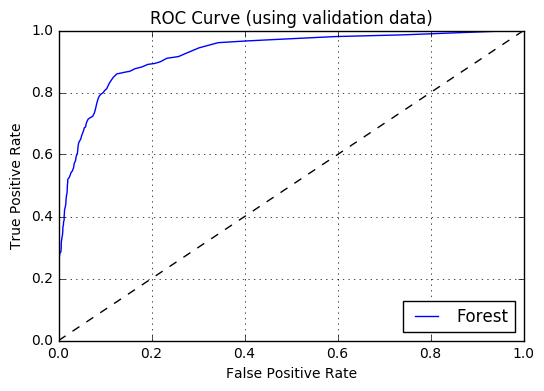

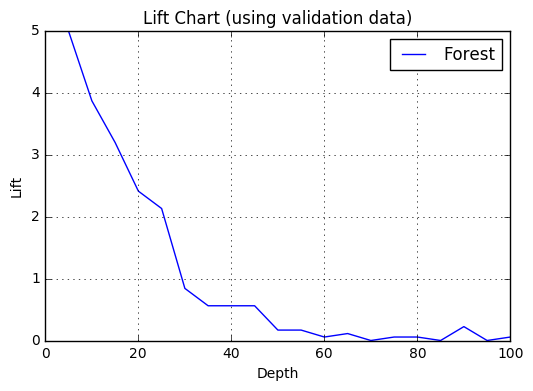

In [14]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in rf_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in rf_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()

### End CAS session

In [15]:
sess.close()